In [1]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 9)

from tim1 import TIM1
from tim2 import TIM2
from hdim import HDIM

In [2]:
files = sorted(glob('data/trades_*.csv'))

In [5]:
N = 32
n = 128

s = []
r = []
e = []

for file in files:
    data = pd.read_csv(file)
    r.append(np.diff(np.log(data.midprice.values)))
    s.append(data.side.values[:-1])
    e.append(data.is_price_cancelling.values[:-1])
    
model_tim = TIM1(n=n, method='moments')
model_tim.fit(s, r)
model_tim2 = TIM2(n=n, method='sgd')
model_tim2.fit(s, e, r)
model_hdim = HDIM(n=n, method='sgd')
model_hdim.fit(s, e, r)

aggregate_impact = {
    n: [] for n in range(-N, N+1) if n % 2 == 0
}

aggregate_impact_tim = {
    n: [] for n in range(-N, N+1) if n % 2 == 0
}

aggregate_impact_tim2 = {
    n: [] for n in range(-N, N+1) if n % 2 == 0
}

aggregate_impact_hdim = {
    n: [] for n in range(-N, N+1) if n % 2 == 0
}

In [7]:
for file in files:
    data = pd.read_csv(file)
    s = data.side.values
    e = data.is_price_cancelling.values
    m = data.midprice.values
    n = 0
    r_tim = model_tim.predict(s)
    r_tim2 = model_tim2.predict(s, e)
    r_hdim = model_hdim.predict(s, e)
    while n + N < len(data):
        r = np.log(m[n+N]) - np.log(m[n])
        S = np.sum(s[n:n+N])
        aggregate_impact[S].append(r)
        aggregate_impact_tim[S].append(np.sum(r_tim[n:n+N]))
        aggregate_impact_tim2[S].append(np.sum(r_tim2[n:n+N]))
        aggregate_impact_hdim[S].append(np.sum(r_hdim[n:n+N]))
        n += 1
                
for n in aggregate_impact:
    if len(aggregate_impact[n]) > 0:
        aggregate_impact[n] = np.mean(aggregate_impact[n])
    else:
        aggregate_impact[n] = .0
        
for n in aggregate_impact_tim:
    if len(aggregate_impact_tim[n]) > 0:
        aggregate_impact_tim[n] = np.mean(aggregate_impact_tim[n])
    else:
        aggregate_impact_tim[n] = .0
        
for n in aggregate_impact_tim2:
    if len(aggregate_impact_tim2[n]) > 0:
        aggregate_impact_tim2[n] = np.mean(aggregate_impact_tim2[n])
    else:
        aggregate_impact_tim2[n] = .0
        
for n in aggregate_impact_hdim:
    if len(aggregate_impact_hdim[n]) > 0:
        aggregate_impact_hdim[n] = np.mean(aggregate_impact_hdim[n])
    else:
        aggregate_impact_hdim[n] = .0

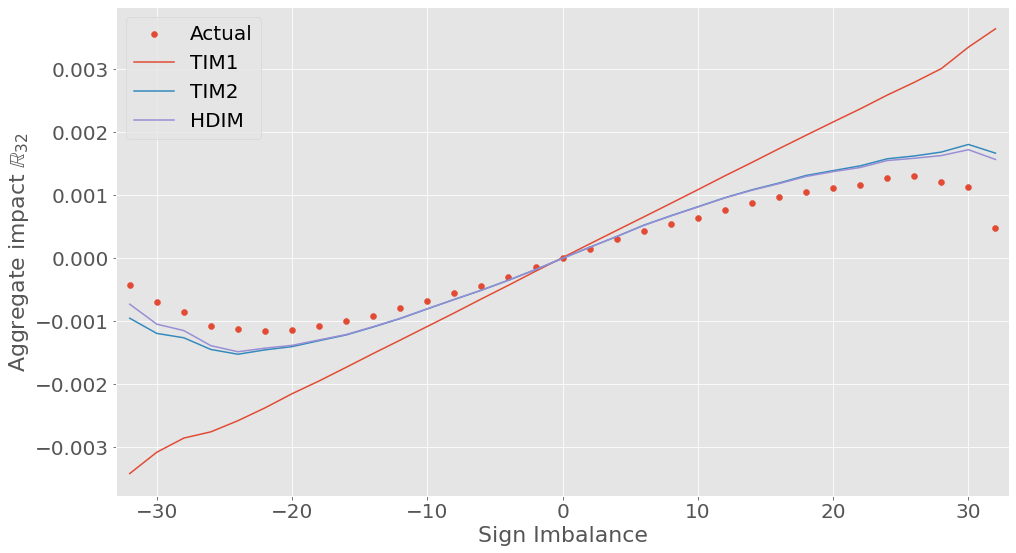

In [9]:
plt.scatter(list(aggregate_impact.keys()), list(aggregate_impact.values()))

plt.plot(list(aggregate_impact_tim.keys()), list(aggregate_impact_tim.values()))
plt.plot(list(aggregate_impact_tim2.keys()), list(aggregate_impact_tim2.values()))
plt.plot(list(aggregate_impact_hdim.keys()), list(aggregate_impact_hdim.values()))

plt.xlim(-33, 33)

plt.xlabel('Sign Imbalance', fontsize=22)
plt.ylabel('Aggregate impact $\mathbb{R}_{32}$', fontsize=22)

plt.legend(['Actual', 'TIM1', 'TIM2', 'HDIM'], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('img/aggregated_impact.png')
plt.show()